In [1]:
# Use this notebook to perform the re-analysis / generation of PP forecasts on tornadoes back to 1950
# Then calculate tornado counts within the probability contours

In [1]:
import skimage.morphology as skmorph
import os
import datetime as dt
import numpy as np
import pandas as pd
import scipy.ndimage as ndimage

In [2]:
from pygridder import Gridder
import pathlib

Variables

In [13]:
dx = 5 # delta x
selem = skmorph.disk(40 / dx) # morphology disk

Load NDFD file

In [7]:
ndfd_path = pathlib.Path('..','..','impacts-data','pas-input-data','ndfd.npz').resolve()

In [8]:
with np.load(ndfd_path) as NPZ:
    lons = NPZ['lons']
    lats = NPZ['lats']

Make dat Gridder

In [14]:
G = Gridder(tx=lons, ty=lats, dx=dx/100)

Read data

In [10]:
dateparser = lambda x: dt.datetime.strptime(x, '%Y-%m-%d %H:%M:%S') + dt.timedelta(hours=6)

In [24]:
data_path = pathlib.Path('..','raw-tor-data','1950-2018_actual_tornadoes.csv')

In [25]:
df = pd.read_csv(data_path, parse_dates=[['date','time']], date_parser=dateparser, index_col=0, keep_date_col=True)

In [102]:
df

,date_time,om,yr,mo,dy,date,time,tz,st,stf,...,wid,ns,sn,sg,f1,f2,f3,f4,fc,weight
0,1950-01-03 17:00:00,1,1950,1,3,1950-01-03,11:00:00,3,MO,29,...,150,2,0,1,0,0,0,0,0,1.0
1,1950-01-03 17:55:00,2,1950,1,3,1950-01-03,11:55:00,3,IL,17,...,130,1,1,1,135,0,0,0,0,1.0
2,1950-01-03 22:00:00,3,1950,1,3,1950-01-03,16:00:00,3,OH,39,...,10,1,1,1,161,0,0,0,0,1.0
3,1950-01-13 11:25:00,4,1950,1,13,1950-01-13,05:25:00,3,AR,5,...,17,1,1,1,113,0,0,0,0,1.0
4,1950-01-26 01:30:00,5,1950,1,25,1950-01-25,19:30:00,3,MO,29,...,300,1,1,1,93,0,0,0,0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63640,2018-12-27 16:15:00,617020,2018,12,27,2018-12-27,10:15:00,3,LA,22,...,25,1,1,1,1,0,0,0,0,1.0
63641,2018-12-27 16:29:00,617021,2018,12,27,2018-12-27,10:29:00,3,MS,28,...,100,1,1,1,163,0,0,0,0,1.0
63642,2018-12-31 18:35:00,617022,2018,12,31,2018-12-31,12:35:00,3,KY,21,...,125,1,1,1,221,0,0,0,0,1.0
63643,2018-12-31 19:43:00,617023,2018,12,31,2018-12-31,13:43:00,3,IN,18,...,50,1,1,1,147,0,0,0,0,1.0


In [38]:
df = df[df.sg == 1]
df = df.reset_index()
#df.iloc[5:50,:]

In [39]:
di = {0: 0.0, 1: 0.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0}
df['weight'] = df['mag'].map(di).fillna(df['mag'])

Outlook Times

In [21]:
outlook_time = '1630'

In [22]:
# Create date array
my_hour = dt.datetime.strptime(outlook_time, '%H%M').hour
my_minute = dt.datetime.strptime(outlook_time, '%H%M').minute

bdt = dt.datetime(1950,1,1,my_hour,my_minute)
edt = dt.datetime(2017,12,31,my_hour,my_minute)

# Create list index of datetimes with a frequency of one per day
dts = pd.date_range(bdt, edt, freq='D')
bdts, edts = dts[:-1],dts[1:]

In [23]:
edts = edts.map(lambda x: x.replace(hour=12,minute=0))

In [25]:
for bdt, edt in zip(bdts[:],edts[:]):
    _df = df[(df['date_time'] >= bdt) & (df['date_time'] < edt) & (df['weight'] == 1.0)]
    if _df.empty:
        continue
    # print(f'From {bdt:%Y-%m-%d %H%M}z to {edt:%Y-%m-%d %H%M}z')
    
    lon1 = _df.slon.values
    lat1 = _df.slat.values
    lon2 = _df.elon.values
    lat2 = _df.elat.values
    
    # Find/remove/replace missing data
    keep = ~np.logical_or(lon1 == 0, lat1 == 0)
    lon1 = lon1[keep]
    lat1 = lat1[keep]
    lon2 = lon2[keep]
    lat2 = lat2[keep]
    lon2[lon2 == 0] = lon1[lon2 == 0]
    lat2[lat2 == 0] = lat1[lat2 == 0]
    
    # Grid tornadoes
    tornlines = G.grid_lines(sxs=lon1, sys=lat1, exs=lon2, eys=lat2)
    mags = _df['weight']
    fcst = G.make_empty_grid(dtype='float')
    for tornline, mag in zip(tornlines, mags):
        fcst[tornline] = mag
        
    # Make practically perfect forecast
    fcst = skmorph.binary_dilation(fcst, selem).astype(float)
    #print(np.max(fcst))
    fcst = ndimage.gaussian_filter(fcst, 120/dx)
    
    # Degrade continuous probs into SPC prob
    # Uncomment if regular probs
    #fcst[fcst < 0.02] = 0
    #fcst[np.logical_and(fcst < 0.05, fcst >= 0.02)] = 0.02
    #fcst[np.logical_and(fcst < 0.10, fcst >= 0.05)] = 0.05
    #fcst[np.logical_and(fcst < 0.15, fcst >= 0.10)] = 0.10
    #fcst[np.logical_and(fcst < 0.30, fcst >= 0.15)] = 0.15
    #fcst[np.logical_and(fcst < 0.45, fcst >= 0.30)] = 0.30
    #fcst[fcst >= 0.45] = 0.45
    
    # Uncomment if sigtor probs
    fcst[fcst < 0.10] = 0
    fcst[fcst >= 0.10] = 0.10
    
    # Save PP forecast
    if outlook_time == '1200':
        outfile = pathlib.Path('pp_forecasts','sigProbs',f'{bdt:%Y%m%d_0600}.npz')
    else:    
        outfile = pathlib.Path('pp_forecasts','sigProbs',f'{bdt:%Y%m%d_%H%M}.npz')
    np.savez_compressed(outfile, fcst=fcst)

Playtime

In [46]:
~np.logical_or([True, False],[False, False])

array([False,  True])

In [3]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs

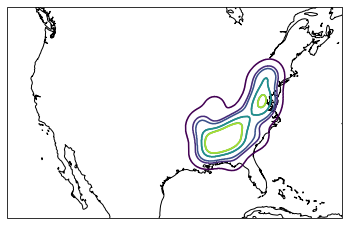

In [9]:
pp = np.load('../pp_forecasts/regProbs/20110427_1630.npz')
 

ax1 = plt.axes(projection=ccrs.LambertConformal())
ax1.coastlines()
ax1.contour(lons, lats, pp['fcst'],transform=ccrs.PlateCarree())

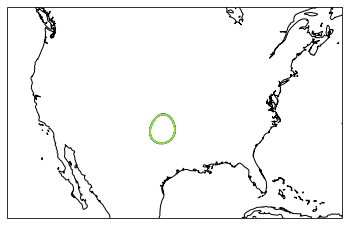

In [80]:
pp = np.load('../pp_forecasts/sigProbs/19990503_1630.npz')

ax1 = plt.axes(projection=ccrs.LambertConformal())
ax1.coastlines()
ax1.contour(lons, lats, pp['fcst'],transform=ccrs.PlateCarree())

In [64]:
np.unique(pp['fcst'])

array([0. , 0.1])

In [28]:
import pygrib as pg

In [29]:
ndfd_string = '/Users/josephpicca/Downloads/ds.ptornado.bin'
ndfd_file = pathlib.Path(ndfd_string) 

In [33]:
with pg.open(ndfd_file.as_posix()) as GRB:
    try:
        vals = GRB[1].values.filled(-1)
    except:
        print('poop')

In [11]:
np.max(pp['fcst'])

0.0

In [23]:
df = pd.read_csv(data_path)
df

,om,yr,mo,dy,date,time,tz,st,stf,stn,...,len,wid,ns,sn,sg,f1,f2,f3,f4,fc
0,1,1950,1,3,1950-01-03,11:00:00,3,MO,29,1,...,9.50,150,2,0,1,0,0,0,0,0
1,2,1950,1,3,1950-01-03,11:55:00,3,IL,17,2,...,3.60,130,1,1,1,135,0,0,0,0
2,3,1950,1,3,1950-01-03,16:00:00,3,OH,39,1,...,0.10,10,1,1,1,161,0,0,0,0
3,4,1950,1,13,1950-01-13,05:25:00,3,AR,5,1,...,0.60,17,1,1,1,113,0,0,0,0
4,5,1950,1,25,1950-01-25,19:30:00,3,MO,29,2,...,2.30,300,1,1,1,93,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
63640,617020,2018,12,27,2018-12-27,10:15:00,3,LA,22,0,...,0.60,25,1,1,1,1,0,0,0,0
63641,617021,2018,12,27,2018-12-27,10:29:00,3,MS,28,0,...,1.29,100,1,1,1,163,0,0,0,0
63642,617022,2018,12,31,2018-12-31,12:35:00,3,KY,21,0,...,0.76,125,1,1,1,221,0,0,0,0
63643,617023,2018,12,31,2018-12-31,13:43:00,3,IN,18,0,...,2.01,50,1,1,1,147,0,0,0,0


### Collecting Tors in Double Sig Area

In [52]:
G = Gridder(tx=lons, ty=lats, dx=dx/100)

In [53]:
fcst = G.make_empty_grid(dtype='float')

For each tornado, make a grid, then mask the grid with the sig tor PP forecast.
If the tornado remains, then append its magnitude to a list

In [54]:
di = {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0}
df['weight'] = df['mag'].map(di).fillna(df['mag'])

In [55]:
outlook_time = '1200'

In [81]:
# Create date array
my_hour = dt.datetime.strptime(outlook_time, '%H%M').hour
my_minute = dt.datetime.strptime(outlook_time, '%H%M').minute

bdt = dt.datetime(1999,5,3,my_hour,my_minute)
edt = dt.datetime(1999,5,4,my_hour,my_minute)

# Create list index of datetimes with a frequency of one per day
dts = pd.date_range(bdt, edt, freq='D')
bdts, edts = dts[:-1],dts[1:]

In [82]:
edts = edts.map(lambda x: x.replace(hour=12,minute=0))

In [84]:
double_sig_tors = []

for bdt, edt in zip(bdts[:],edts[:]):
    _df = df[(df['date_time'] >= bdt) & (df['date_time'] < edt) & (df['weight'] == 1.0)]
    if _df.empty:
        continue
    # print(f'From {bdt:%Y-%m-%d %H%M}z to {edt:%Y-%m-%d %H%M}z')
    
    lon1 = _df.slon.values
    lat1 = _df.slat.values
    lon2 = _df.elon.values
    lat2 = _df.elat.values
    
    # Find/remove/replace missing data
    keep = ~np.logical_or(lon1 == 0, lat1 == 0)
    lon1 = lon1[keep]
    lat1 = lat1[keep]
    lon2 = lon2[keep]
    lat2 = lat2[keep]
    lon2[lon2 == 0] = lon1[lon2 == 0]
    lat2[lat2 == 0] = lat1[lat2 == 0]
    
    for i in range(len(lat1)):
        # Grid tornadoes
        tornlines = G.grid_lines(sxs=lon1[i], sys=lat1[i], exs=lon2[i], eys=lat2[i])
        mags = _df['weight']
        fcst = G.make_empty_grid(dtype='float')
        for tornline, mag in zip(tornlines, mags):
            fcst[tornline] = mag
        
        if (np.max(np.ma.masked_where(pp['fcst']<0.05,fcst)) > 0):
        #if (np.max(np.ma.masked_where(vals<0.05,fcst)) > 0):
            double_sig_tors.append(i)
    
    
    '''
    # Make practically perfect forecast
    fcst = skmorph.binary_dilation(fcst, selem).astype(float)
    #print(np.max(fcst))
    fcst = ndimage.gaussian_filter(fcst, 120/dx)
    
    # Degrade continuous probs into SPC prob
    # Uncomment if regular probs
    #fcst[fcst < 0.02] = 0
    #fcst[np.logical_and(fcst < 0.05, fcst >= 0.02)] = 0.02
    #fcst[np.logical_and(fcst < 0.10, fcst >= 0.05)] = 0.05
    #fcst[np.logical_and(fcst < 0.15, fcst >= 0.10)] = 0.10
    #fcst[np.logical_and(fcst < 0.30, fcst >= 0.15)] = 0.15
    #fcst[np.logical_and(fcst < 0.45, fcst >= 0.30)] = 0.30
    #fcst[fcst >= 0.45] = 0.45
    
    # Uncomment if sigtor probs
    fcst[fcst < 0.10] = 0
    fcst[fcst >= 0.10] = 0.10
    
    # Save PP forecast
    if outlook_time == '1200':
        outfile = pathlib.Path('pp_forecasts','sigProbs',f'{bdt:%Y%m%d_0600}.npz')
    else:    
        outfile = pathlib.Path('pp_forecasts','sigProbs',f'{bdt:%Y%m%d_%H%M}.npz')
    np.savez_compressed(outfile, fcst=fcst)'''

In [94]:
may31999 = _df.iloc[double_sig_tors,:].groupby('mag').count()['weight']/len(double_sig_tors)

*Aggregating the tornado ratings*

- 27 April 2011: apr272011
- 11 April 1965: apr111965
- 3 April 1974: apr31974
- 31 May 1985: may311985
- 3 May 1999: may31999

Get the average rating distribution of these five events

In [96]:
apr272011.add(apr111965.add(apr31974.add(may311985.add(may31999,fill_value=0),fill_value=0),fill_value=0),fill_value = 0)/5

mag
0    0.194284
1    0.245682
2    0.170749
3    0.171552
4    0.189548
5    0.028185
Name: weight, dtype: float64

In [4]:
import pygrib as pg

In [5]:
ndfd_string = '../../sampleinputs/sigtorn_day1_grib2_1200_20110427061047'
tor_file = pathlib.Path(ndfd_string) 

In [6]:
with pg.open(tor_file.as_posix()) as GRB:
    try:
        vals = GRB[1].values.filled(-1)
    except AttributeError:
        vals = GRB[1].values
        
    lats,lons = GRB[1].latlons()

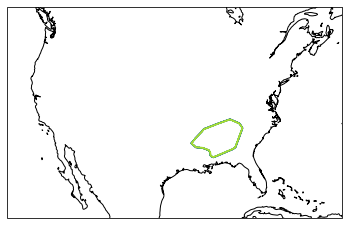

In [7]:
ax1 = plt.axes(projection=ccrs.LambertConformal())
ax1.coastlines()
ax1.contour(lons, lats, vals,transform=ccrs.PlateCarree())

In [21]:
np.max(vals)

10.0

In [101]:
(np.array([.5,.2,.3])*14 + np.array([.2,.5,.3]))/15

array([0.48, 0.22, 0.3 ])